# preparacao do dataset: dados para treino e validacao

In [1]:
import cv2
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

relembrar o estado atual do dataset

In [2]:
df_train03 = pd.read_pickle("Train_v03.pkl")

In [3]:
df_train03.sample(3)

,ID,boil_nbr,pan_nbr,boil_polygon,pan_polygon,img_origin,placement,hows_polygon
1020,IDIcHJxLRX,[],[1],[],"[[(2055.0, 1950.0), (2070.0, 1836.0), (2304.0,...",D,roof,ok
1065,IDJRDGv,[],[1],[],"[[(1773.0, 1896.0), (1518.0, 1588.0), (1716.0,...",D,roof,ok
996,IDI8XWI,"[1, 1, 1, 1, 1]",[],"[[(188.0, 268.0), (172.0, 256.0), (192.0, 232....",[],S,S-unknown,ok


In [4]:
df_train03["hows_polygon"].value_counts()

hows_polygon
ok            2767
quase          260
a direita      160
a esquerda     123
lixo             2
Name: count, dtype: int64

*small mistakes were made...*

In [5]:
df_train03.loc[496, "hows_polygon"] = "a esquerda"
df_train03.loc[1895, "hows_polygon"] = "a esquerda"
df_train03.loc[2356, "hows_polygon"] = "quase"

tendo em conta que ja sabemos as imagens que têm os poligonos bem marcados e as que não, vamos tentar dar fix nas imagens cujos poligonos estao desvidas mais para a direita ou para a esquerda, mantes os ok, e ignorar os restantes, pelo menos por enquanto

vamos ver se atraves de umas mudancas na classe dos dados é sufciente para que eles fiquem ok

In [6]:
def polygons_to_segmentation_mask(polygons, image):
    for polygon, val in polygons:
        poly = np.array([polygon], dtype=np.int32)
        cv2.fillPoly(image, [poly], val)
    return image

class SupervisedDataset(Dataset):
    def __init__(self, data_path, dataframe, transforms):
        self.root_path = data_path
        self.transforms = transforms
        self.data = dataframe

        self.images = []
        self.targets = []
        self.vertex_boil = []
        self.vertex_pan = []
        self.nr_boild = []
        self.nr_pan = []
        self.id = []
        self.hows_polygon = []

        for idx in self.data.index:
            if self.data['hows_polygon'][idx] not in ['lixo', 'quase']:
                self.images.append(os.path.join(self.root_path, self.data['ID'].iloc[idx] + '.jpg'))
                self.vertex_boil.append(self.data['boil_polygon'].iloc[idx])
                self.vertex_pan.append(self.data['pan_polygon'].iloc[idx])
                self.nr_boild.append(self.data['boil_nbr'].iloc[idx])
                self.nr_pan.append(self.data['pan_nbr'].iloc[idx])
                self.id.append(self.data['ID'].iloc[idx])
                self.hows_polygon.append(self.data['hows_polygon'].iloc[idx])

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert("RGB")
        size = img.size
        img = self.transforms(img)
        vertices_boil = self.vertex_boil[idx]
        vertex_pan = self.vertex_pan[idx]
        hows_polygon = self.hows_polygon[idx]

        mask = np.zeros((img.shape[1],img.shape[2]),dtype = np.int32)
        all_polygons = []
        for polygon in vertices_boil:
            lst2 = []
            lst1 = []
            for i in range(len(polygon)):
                v1 = list(polygon[i])
                v1[0] = (v1[0]*512)/size[0]
                v1[1] = (v1[1]*512)/size[1]
                if hows_polygon == 'a esquerda':
                    v1[0] += 64
                    v1[1] += 64
                elif hows_polygon == 'a direita':
                    v1[0] -= 83
                    v1[1] -= 83
                lst2.append((v1[0],v1[1]))
            lst1.append(lst2)
            lst1.append(5) #boiler
            all_polygons.append(lst1)
        for polygon in vertex_pan:
            lst2 = []
            lst1 = []
            for i in range(len(polygon)):
                v1 = list(polygon[i])
                v1[0] = (v1[0]*512)/size[0]
                v1[1] = (v1[1]*512)/size[1]
                if hows_polygon == 'a esquerda':
                    v1[0] += 64
                    v1[1] += 64
                elif hows_polygon == 'a direita':
                    v1[0] -= 83
                    v1[1] -= 83
                lst2.append((v1[0],v1[1]))
            lst1.append(lst2)
            lst1.append(6) #pan
            all_polygons.append(lst1)
        mask = polygons_to_segmentation_mask(all_polygons, mask)
        return img, mask.astype(int)
    
transforms = T.Compose([
    T.Resize((512,512)),  # Resize to a fixed size
    T.ToTensor(),          # Convert to PyTorch tensor
])
df_train = df_train03
data_path = 'images'
train_data = SupervisedDataset(data_path, df_train, transforms)

vamos agora verificar se estas alterações são suficientes para que as imagens fiquem ok (as "a direita" e as "a esquerda")

In [7]:
df_train_new = pd.read_pickle("Train_v03.pkl")
df_train_new["hows_polygon_v2"] = df_train03["hows_polygon"].apply(lambda x: x if x in ["ok", "lixo", "quase"] else None)
df_train_new.drop(df_train_new[df_train_new["hows_polygon_v2"].isin(["lixo", "quase"])].index, inplace=True)
df_train_new.reset_index(drop=True, inplace=True)


def get_image_and_mask(index):
    img, mask = train_data[index]
    img = img.permute(1, 2, 0).numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.imshow(mask, cmap='Paired', alpha=0.5)
    plt.title(f'{train_data.id[index]}: Yellow {train_data.nr_pan[index]} & Orange {train_data.nr_boild[index]}')
    plt.axis('off')
    plt.show()

# loop para verificacao das imagens
"""
for index, row in df_train_new.iterrows():
    if row["hows_polygon_v2"] == None:
        row_id = row["ID"]

        # verificar se o id está correto
        if train_data.id[index] != row_id:
            print(f"Erro: {index} - {row_id} - {train_data.id[index]}")
            break

        # se o id estiver correto, mostrar a imagem
        get_image_and_mask(index)
        hows_polygon = input("How's the polygon? ok, quase ou exit? ")
        while hows_polygon not in ["exit", "ok", "quase"]:
            hows_polygon = input("How's the polygon? ok, quase ou exit? ")

        # se o input for diferente de "exit", guardar o input
        if hows_polygon != "exit":
            df_train_new.loc[index, "hows_polygon_v2"] = hows_polygon

        # se o input for "exit", parar o loop
        elif hows_polygon == "exit":
            break
"""
df_train_new["hows_polygon_v2"] = ["ok"] * len(df_train_new)

df_train_new["hows_polygon_v2"].value_counts()

hows_polygon_v2
ok    3049
Name: count, dtype: int64

verificou-se que com as alteracoes feitas nas classe, apenas preciamos de exlcluir o "lixo" e o "quase" para que todos os poligonos fiquem bem marcados. quantas imagens perdemos ao todo?

In [8]:
a = len(train_data) - len(pd.read_pickle("Train_v03.pkl"))
print(f"Temos então {len(train_data)} imagens.")
print(f"Ao todo, perdemos {abs(a)} imagens.")

Temos então 3049 imagens.
Ao todo, perdemos 263 imagens.


---

assim sendo, podemos então separar os dados em treino e validação (teste) na proporção 80/20

vamos primeiro remover as imagens que não têm poligonos bem marcados

In [9]:
df_train_before_split = df_train03.drop(df_train03[df_train03["hows_polygon"].isin(["lixo", "quase"])].index, inplace=False)
df_train_before_split.reset_index(drop=True, inplace=True)

df_train_before_split.sample(3)

,ID,boil_nbr,pan_nbr,boil_polygon,pan_polygon,img_origin,placement,hows_polygon
177,ID3NUln19v,[],"[1, 1]",[],"[[(1146.0, 1378.0), (1030.0, 1168.0), (1161.0,...",D,roof,ok
2252,IDjY25GD,[],[1],[],"[[(1473.0, 1219.0), (1791.0, 1011.0), (2181.0,...",D,roof,ok
1112,IDMUyb3XgcH8zK3Wj,[],"[51, 51, 51, 51]",[],"[[(437.0, 249.0), (483.0, 257.0), (462.0, 405....",S,S-unknown,ok


verificar que a remoção foi feita corretamente

In [10]:
set(df_train_before_split["hows_polygon"])

{'a direita', 'a esquerda', 'ok'}

e agora separar os dados em treino e validação

In [11]:
# mix the data
df = df_train_before_split.sample(frac=1, random_state=42).reset_index(drop=True)

# split the data
split_idx = int(0.8 * len(df))
train_df = df[:split_idx]
val_df = df[split_idx:]

# mostrar shapes
print("Train DF:", train_df.shape)
print("Test DF:", val_df.shape)

Train DF: (2439, 8)
Test DF: (610, 8)


e agora guardá-los

In [12]:
train_df.to_pickle("Model_Train.pkl")
val_df.to_pickle("Model_Val.pkl")

---

agora que já temos os dados para treino e validação, vamos guardar a class do python para que possamos usar mais tarde, num ficheiro python: **SupvDset.py**

e para usar, basta fazer o seguinte:

In [13]:
import torchvision.transforms as T
import pandas as pd

# importar a classe
from SupvDset import SupervisedDataset


# definir variaveis
data_path = 'images'
df_train = pd.read_pickle("Model_Train.pkl")
transforms = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),
])

# aplicar a classe
train_data = SupervisedDataset(data_path, df_train, transforms)

e se quisermos ver as imagens, basta fazer o seguinte:

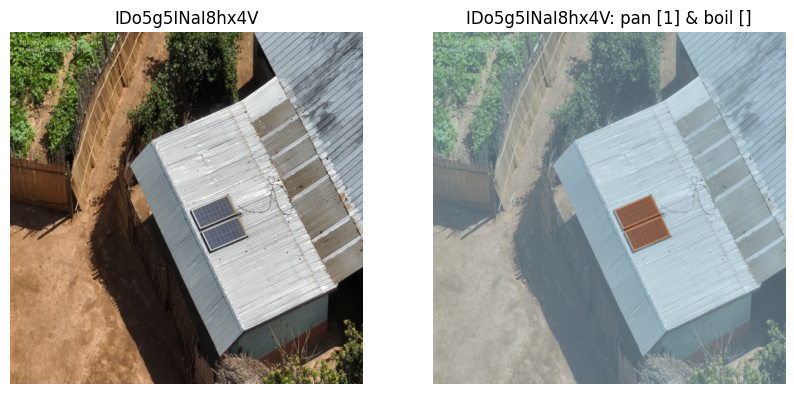

In [14]:
import matplotlib.pyplot as plt
import numpy as np  

img, mask = train_data[1]
img = img.permute(1, 2, 0).numpy()

plt.figure(figsize=(10, 5))  

# show the image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f'{train_data.id[100]}')
plt.axis('off')

# show the mask with the image
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.imshow(mask, cmap='Paired', alpha=0.5)
plt.title(f'{train_data.id[100]}: pan {train_data.nr_pan[100]} & boil {train_data.nr_boild[100]}')
plt.axis('off')

plt.show()